## Introduction

**Sentinel-2** provides a powerful way to generate various views of the Earth's surface.<br>
For example, a **True Colour Image** (TCI) is created by combining the red, green, and blue bands, resulting in a view that looks natural to the human eye.<br>
In contrast, **False Colour Images** (FCI) are created from alternative band combinations to highlight features not normally visible. Using the shortwave infrared, near-infrared, and red channels, for instance, allows us to create an image that clearly distinguishes healthy vegetation from damaged or burnt areas, providing a crucial tool for environmental monitoring.<br>

This notebook will take you through a practical example of how the `.zarr` satellite data can be used to monitor a wildfire. We will use items available at the [EOPF STAC Catalog]() to visualise a specific event, comparing the landscape before and after the fire to determine the extent of the damage. This comparison is made possible by using different combinations of spectral bands.

### By the end of this tutorial, we will be able to...



- 💨 Create cloud-free layers from Sentinel-2 L2A data for a clear view of the Earth's surface.
- ✂️ Extract and clip specific areas of interest from satellite imagery using a STAC catalog and reprojected bounding boxes.
- 🛰️ Set a starting point for wildfire events analysis by visualising vegetation and land conditions using Sentinel-2 L2A imagery.

<hr>

#### Import libraries

In [1]:
from distributed import LocalCluster
from pystac_client import Client
import numpy as np
import xarray as xr
import time
import matplotlib.pyplot as plt
from pyproj import Transformer
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from skimage import exposure
from matplotlib.colors import BoundaryNorm, ListedColormap
from shapely.geometry import box 

#### Helper functions

##### `validate_scl()`

Creates a boolean mask to identify valid pixels in a Sentinel-2 Scene Classification (SCL) dataset by excluding invalid land cover types.

Recieves:

- `scl` : An xarray.DataArray representing the Scene Classification (SCL) band from a Sentinel-2 image.

In [2]:
def validate_scl(scl):
# A list of SCL values to be considered invalid
    invalid = [0, 1, 3, 7, 8, 9]
# Return a boolean mask where True indicates a valid pixel (i.e., not in the invalid list)
    return ~scl.isin(invalid)

##### `mask_sub_utm()`
Performs the masking over a `.zarr` asset by subsetting it to a specified rectangular area defined by row and column indices.

Recieves:

- `zarr_asset` : The input Zarr array asset.
- `rows` : A list or array of row indices defining the vertical extent.
- `cols` : A list or array of column indices defining the horizontal extent.

In [3]:
def mask_sub_utm(zarr_asset, rows, cols):
# Calculates the minimum and maximum row and column indices
    row_min, row_max = rows.min(), rows.max()
    col_min, col_max = cols.min(), cols.max()
# It then subsets the zarr_asset using these indices
    masked_asset = zarr_asset.isel(
    y=slice(row_min, row_max + 1), x=slice(col_min, col_max + 1)
)
    return masked_asset

##### `normalisation_str_gm()`

Applies percentile-based contrast stretching and gamma correction to a band.

Recieves:

- `band_array` : the extracted `xarray` for the selected band
- `p_min` : percentile min value
- `p_max`: percentile max value
- `gamma_val`: gamma correction

In [4]:
def normalisation_str_gm(band_array, p_min, p_max, gamma_val):

    # Calculate min and max values based on percentiles for stretching
    min_val = np.percentile(band_array[band_array > 0], p_min) if np.any(band_array > 0) else 0
    max_val = np.percentile(band_array[band_array > 0], p_max) if np.any(band_array > 0) else 1

    # Avoid division by zero if min_val equals max_val
    if max_val == min_val:
        stretched_band = np.zeros_like(band_array, dtype=np.float32)
    else:
        # Linear stretch to 0-1 range
        stretched_band = (band_array - min_val) / (max_val - min_val)

    # Clip values to ensure they are within [0, 1] after stretching
    stretched_band[stretched_band < 0] = 0
    stretched_band[stretched_band > 1] = 1

    # Apply gamma correction
    gamma_corrected_band = np.power(stretched_band, 1.0 / gamma_val)

    # Returns the corrected array:
    return gamma_corrected_band


##### `lat_lon_to_utm_box()`

Converts the latitude and longitude coordinates of a bounding box from a geographic system to the UTM (Universal Transverse Mercator) coordinate system.

Recieves:

- `bot_left` : A tuple or list containing the longitude and latitude of the bottom-left corner.
- `top_right` : A tuple or list containing the longitude and latitude of the top-right corner.

In [5]:
def lat_lon_to_utm_box(bot_left,top_right):
    # Longitude and latitude of the bottom-left corner
    west_utm, south_utm = transformer.transform(bot_left[0],bot_left[1])
    # Longitude and latitude of the top-right corner
    east_utm, north_utm = transformer.transform(top_right[0],top_right[1])

    # A new list with the converted UTM coordinates
    return [ west_utm, south_utm , east_utm , north_utm ]

##### `zarr_mask_utm()`
This function creates a boolean mask to identify the rows and columns within a Zarr dataset that fall within a specified bounding box, assuming UTM coordinates.

Recieves:
- `bounding_box` : A tuple or list containing (min_longitude, min_latitude, max_longitude, max_latitude).
- `zarr` : The input Zarr dataset, expected to have 'x' and 'y' dimensions corresponding to longitude and latitude/UTM coordinates.

In [6]:
def zarr_mask_utm ( bounding_box, zarr):
# Unpack the bounding box coordinates for clarity
    min_lon, min_lat, max_lon, max_lat = bounding_box
# Create boolean masks for longitude and latitude dimensions based on the bounding box
    lon_mask = (zarr['x'] >= min_lon) & (zarr['x'] <= max_lon)
    lat_mask = (zarr['y'] >= min_lat) & (zarr['y'] <= max_lat)
# Combine the individual masks to create a single bounding box mask
    bbox_mask = lon_mask & lat_mask
# Find the columns and row indices where the combined mask is True
    cols, rows  = np.where(bbox_mask)

    return cols, rows

<hr>

## Setting up the Environment
The process begins by setting up a parallel computing environment. This allows for efficient data processing by creating a **virtual cluster** on our local machine.<br>
This cluster consists of a scheduler (the "brain") and several workers (the "hands"), which enables faster processing of large datasets by breaking down tasks and running them in parallel. <br>
A client is then created to manage communication between the code and this cluster.

For more information, feel free to visit the **dask** [documentation](https://docs.dask.org/en/stable/) and the tutorial [How to use dask](http://docs.dask.org/en/stable/#how-to-use-dask).

In [7]:
# we are interested in the performance the code will have
st = time.time()

cluster = LocalCluster()
client = cluster.get_client()
client

/opt/anaconda3/envs/eopf_env_wf/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 49837 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:49838' processes=5 threads=10, memory=24.00 GiB>

### STAC Connection
Data is retrieved from the [EOPF STAC Catalogue]() endpoint. Once we are connected, a bounding box and a date range can be defined to specify the area and time of interest.

In [8]:
eopf_stac_api_root_endpoint = "https://stac.core.eopf.eodc.eu/" #root starting point
eopf_catalog = Client.open(url=eopf_stac_api_root_endpoint) # calls the selected url
eopf_catalog

<Client id=eopf-sample-service-stac-api>

## The Event

Between January and July 2025, Italy experienced a significant number of wildfires([Italian National Institute of Health (ISS)](https://alleanzacontroilcancro.it/en/istituto/istituto-istituto-superiore-sanita/)), with approximately 700 recorded incidents burning over 320 square kilometres.<br>

We will focus on a specific fire that occurred in the Province of Nuoro in the Italian region of Sardinia, on **June 10th, 2025**. [The European Forest Fire Information System (EFFIS)](https://forest-fire.emergency.copernicus.eu/?pk_vid=1c5add39a04f87ba17556907226604b6) estimated that it consumed an estimated 1000 hectares. Based on this area, we can expect it to be clearly visible in Sentinel-2 imagery with a 20-metre resolution.


To analyse this event, we will use the [EOPF STAC Catalog](https://stac.browser.user.eopf.eodc.eu/) to filter for relevant items.<br>
We need to define specific parameters for our query, including two key dates for our comparison: one date for a pre-fire view, **3rd of June 2025** (one week before the event) and a second for the post-fire view on **21st June 2025** (10 days after). <br>
We will also define the area of interest and set the appropriate re-projection parameters to ensure a smooth and efficient workflow.

In [9]:
# The timeframe and area of interest for our filtering
def_collection = 'sentinel-2-l2a' # collection
# Before the fire:
pre_f  = '2025-06-03'
# After the fire:
post_f = '2025-06-21'

search_bbox = (8.847198,40.193395,8.938865,40.241895)

# Definition of the transformer parameters from lat/lon to UTM that ensure
# correct overlay of layers
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32632", always_xy=True)

t_utm_to_deg = Transformer.from_crs("EPSG:32632","EPSG:4326", always_xy=True)

## Pre-Fire Visualisation

The first step is to create a **visual representation** of our area of interest using compositions from spectral bands that belong to the [Sentinel-2 L2A collection]().<br>
We will use the parameters we defined earlier to query the collection and retrieve the specific pre-fire images needed for our analysis.


In [10]:
# Interest timeframe parameters for the filtering
date_pre = pre_f + 'T00:00:00Z/' + pre_f + 'T23:59:59.999999Z' # interest period
s2_col = list(eopf_catalog.search(
                bbox= search_bbox, # area
                datetime= date_pre, #time frame
                collections=def_collection # collection
                ).item_collection())

av_urls = [item.assets["product"].href for item in s2_col]  # stores the available Items URLs
print("Search Results:")
print('Total Items Found for Sentinel-2 L2A over _:  ',len(av_urls))

Search Results:
Total Items Found for Sentinel-2 L2A over _:   1


After obtaining the available items, we will retrieve **the last element** from the resulting list of URL. This item is the first generated one within the specified timeframe.<br>
Key information from the item's properties is also extracted for an easier identification. 

In [11]:
# We are interested in the datasets contained in the measurements bands for True Colour and False Colour Composites.
s2_zarr = xr.open_datatree(
    av_urls[-1], engine="zarr", #we always get the earliest one (the first available item goes last)
    chunks={}
    )

# Store interest parameters for further plotting:
date = s2_zarr.attrs['stac_discovery']['properties']['start_datetime'][:10]
time_zarr = s2_zarr.attrs['stac_discovery']['properties']['start_datetime'][11:19]
target_crs = s2_zarr.attrs["stac_discovery"]["properties"]["proj:epsg"]

print(f'Item for the {date} at {time_zarr}')

/var/folders/hr/vlzgj7wj51l7ps0dxp4wp08r0000gn/T/ipykernel_2039/1164334403.py:2: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  s2_zarr = xr.open_datatree(
/var/folders/hr/vlzgj7wj51l7ps0dxp4wp08r0000gn/T/ipykernel_2039/1164334403.py:2: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, whic

Item for the 2025-06-03 at 10:10:41


The spectral bands we will need for our analysis are found within the `/reflectance` group, specifically under the `r20m` subgroup.<br>
Before directly processing our interest assets, the data must be cleaned to ensure its accuracy.<br>

To do this, we will use the **Scene Classification Layer** (SCL) available inside the `.zarr` item, which is a separate asset located under the `/classification/r20m` group.<br>
The SCL provides a classification for each pixel, identifying elements such as clouds, cloud shadows, or areas with no data. By using the pre-defined. `validate_scl()` function, we can create a boolean mask that identifies these invalid pixels. This enables us to remove them and generate a clean, cloud-free composite.

In [12]:
# Extract the resolution group we are interested to analyse over:
zarr_meas = s2_zarr.measurements.reflectance.r20m

# Extractthe cloud free mask at 20m resolution:
l2a_class_20m = s2_zarr.conditions.mask.l2a_classification.r20m.scl

valid_mask = validate_scl(l2a_class_20m)  # Boolean mask (10980x10980)

The visualisation we are intending to create must cover a larger extent than the specific fire area, which helps us better understand the event’s overall spatial impact. For this, a bounding box is then generated to visually pinpoint the fire’s precise location within this wider composite image.

In [13]:
# Defining a larger bounding box for better visualisation:
bbox_vis = (8.649555,40.073583,9.127893,40.343840)

# A fixed geographic bounding box to highlight the AOI in the map format
map_box = search_bbox

Coordinate re-projection is necessary since the area of interest is initially defined in EPSG: 4326.<br>
Once the area is defined, the imagery is masked using the defined `bbox_utm`. After extracting the area, only the valid pixels are selected.

In [14]:
# A new list with the converted UTM coordinates
bbox_utm = lat_lon_to_utm_box((bbox_vis[0], bbox_vis[1]),(bbox_vis[2], bbox_vis[3]))

# Use the box() function to create a polygon from the coordinates
map_box = box(map_box[0],map_box[1],map_box[2],map_box[3])

# Boolean mask for the 'x' dimension (longitude/easting)
x_mask = (zarr_meas['x'] >= bbox_utm[0]) & (zarr_meas['x'] <= bbox_utm[2])
# Boolean mask for the 'y' dimension (latitude/northing)
y_mask = (zarr_meas['y'] >= bbox_utm[1]) & (zarr_meas['y'] <= bbox_utm[3])

# Combined mask for the bounding box
bbox_mask = x_mask & y_mask

# Extract row and column indices where the mask is True
cols , rows = np.where(bbox_mask)

### True Colour Image

To get a familiar view of the fire area, a True Colour Image (TCI) can help us spot visually the presence of smoke or anomalies from a top view over Earth's surface.<br>

Once we have created the necessary masks, we can proceed to process the assets we are interested in.<br>

For the composite creation, `zarr_meas` contains the assets we are interested in. The TCI composite makes use of the **red** (B04), **green** (B03), and **blue** (B02) bands to create a view that looks natural to the human eye. <br>

The `zarr` format, allows us to apply the conditions we are interested on the go, such as the SLC filtering we had previously defined.<br>

A glimpse of the green band after processing the valid pixels, can be appreciated.

Text(0.5, 1.0, 'Red Reflectance (b04)')

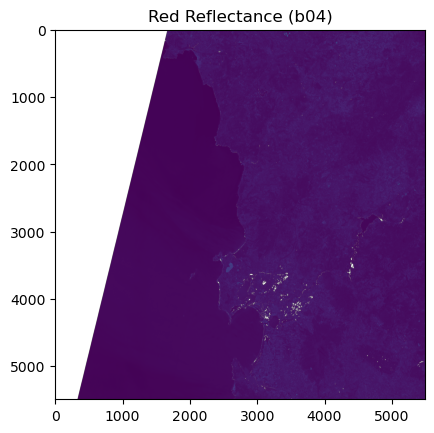

In [15]:
# True colour channels we are interested to retrieve coposite:
tc_red  = 'b04'
tc_green= 'b03'
tc_blue = 'b02'

# The tc_red, tc_green, and tc_blue variables are inputs specifying the band names
red = zarr_meas[tc_red].where(valid_mask)
gre = zarr_meas[tc_green].where(valid_mask)
blu = zarr_meas[tc_blue].where(valid_mask)

# Visualising the red band:
plt.imshow(gre)
plt.title('Red Reflectance (b04)')

As we start the processing, the next step would be delimiting the assets to bounding box we want to have over the area of interest.<br>
We use our `mask_sub_utm()` function, and after obtaining the enclosed pixels, we proceed to access on disk the data we will be processing.<br>
<br>
It is also important to note that `.zarr` contains **x** and **y** information for each of the pixels, and storing this values for a further geolocalisation of our item of interest is essential. <br>
After this clip, we can for example, visualise the **blue** (B02) clipped asset.

Text(0.5, 1.0, 'Clipped Blue Reflectance (b02)')

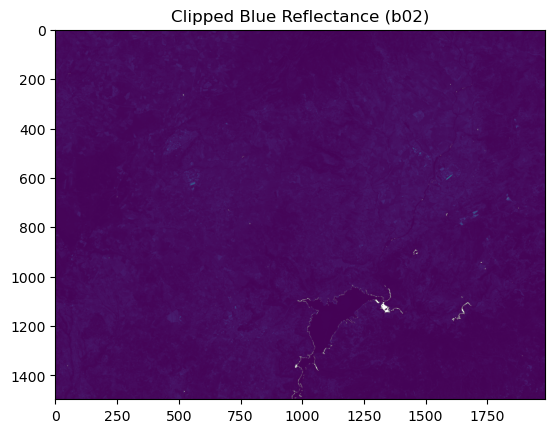

In [16]:
# The mask_sub_utm() function takes the bands and masks them to the valid rows and columns from the bbox_mask
red = mask_sub_utm(red,rows, cols).values
gre = mask_sub_utm(gre,rows, cols).values
blu = mask_sub_utm(blu,rows, cols).values

# The zarr_meas group is the input dataset containing the dimensions
# by slicing the 'y' dimension array based on the minimum and maximum row indices
y_zarr = zarr_meas['y'].isel(y=slice(rows.min(), rows.max() + 1)).values
# also, the same for the 'x' dimension array based on the minimum and maximum column indices
x_zarr = zarr_meas['x'].isel(x=slice(cols.min(), cols.max() + 1)).values

# We transform the original x,y bbox from our clip to decimal degree coordinates
map_ext_deg_pre = list(t_utm_to_deg.transform(np.nanmin(x_zarr),np.nanmin(y_zarr)) + 
                   t_utm_to_deg.transform(np.nanmax(x_zarr),np.nanmax(y_zarr)))

# Visualising the clipped red band:
plt.imshow(blu)
plt.title('Clipped Blue Reflectance (b02)')

To create the composite image, it is crucial to **normalise** each of the input assets.<br>

Normalisation, ensures that the assets (colour channels) have a consistent and predictable range of values. This supports optimal data processing and removes the influence of external factors (like changing light conditions) allowing a meaningful comparison among generated composites.

The `normalisation_str_gm()` function achieves this by scaling the reflectance values to a standard range (0-255) using the percentile-based method.<br>

Once the values for our three assets have been normalised, they can be stacked in an **R-G-B** format to generate the initial True Colour Image (TCI).

Text(0.5, 1.0, 'RGB Composite')

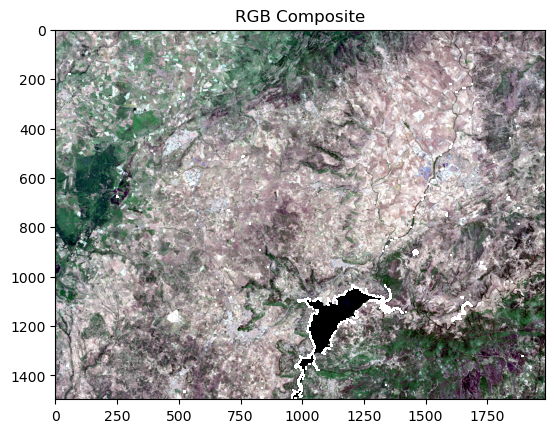

In [17]:
# Input: percentile range for contrast stretching
contrast_stretch_percentile=(2, 98)
# Input: gamma correction value
gamma=1.8

# Apply normalisation to the red, green and blue bands using the specified percentile and gamma values
red_processed = normalisation_str_gm(red, *contrast_stretch_percentile, gamma)
green_processed = normalisation_str_gm(gre, *contrast_stretch_percentile, gamma)
blue_processed = normalisation_str_gm(blu, *contrast_stretch_percentile, gamma)

# We stack the processed red, green, and blue arrays
rgb_composite_sm = np.dstack((red_processed, green_processed, blue_processed)).astype(np.float32)

plt.imshow(rgb_composite_sm)
plt.title('RGB Composite')


The image is currently displayed with a neutral colour ramp and with the non-valid masked pixels. Some of the details can be enhanced based on the information the overall composite contains. <br>

For this, we can apply a **histogram equalisation**. This technique will adjust the brightness and improve the visibility of details within our image. <br>
Through the `skimage` library, we can apply the `exposure.equalize_adapthist()` function. This method creates a more natural-looking and visually balanced composite, delivering the following result.

Text(0.5, 1.0, 'Equalised Composite')

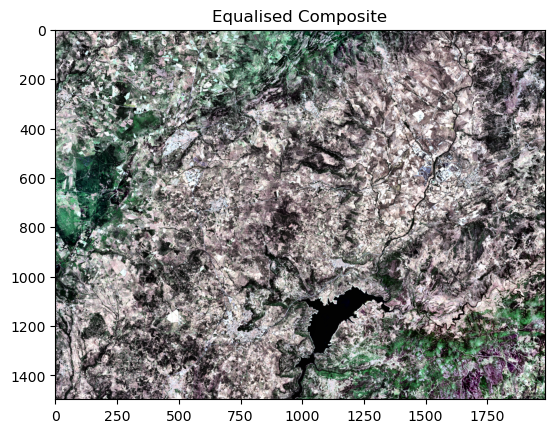

In [18]:
#Adding equalisation from skimage:
fire_tc = exposure.equalize_adapthist(rgb_composite_sm)

plt.imshow(fire_tc)
plt.title('Equalised Composite') # Add a title for clarity

### False Colour Image

Next, a **False Colour Image** (FCI) is created to provide a clearer overview of vegetation health.<br>
This image uses the **Shortwave Infrared** (B12), **Near-Infrared** (B8a), and **Blue** (B02) assets. This specific combination enhances the distinction between healthy vegetation, which appears green, and damaged or burnt areas, which are shown in vivid, contrasting colours.<br>
The proposed composite will help us to clearly highlight the full extent of the fire's impact.

In [19]:
# The false colour channels we are interested to retrieve coposite:
fc_swir = 'b12'
fc_nir =  'b8a'
fc_blue = 'b02'

Following the same principle of the TCI's creation, after choosing the interest bands, a validation of the pixels and a clip based on the bounding box is applied.

In [20]:
# The zarr_meas object is the input dataset containing the bands, fc_red, fc_green, fc_blue specify the bands
# The where() method is used to apply the boolean valid_mask to the bands
swir = zarr_meas[fc_swir].where(valid_mask)
nir =  zarr_meas[fc_nir].where(valid_mask)
blu =  zarr_meas[fc_blue].where(valid_mask)

# The mask_sub_utm() function takes the bands and masks them to the specified rows and columns
swir = mask_sub_utm(swir,rows, cols).values
nir = mask_sub_utm(nir,rows, cols).values
blu = mask_sub_utm(blu,rows, cols).values

Once the retrieved area is set in our defined arrays, we apply our normalisation function, followed by the stacking of the processed layers. <br>
The composite created can be appreciated. 

Text(0.5, 1.0, 'False Composite')

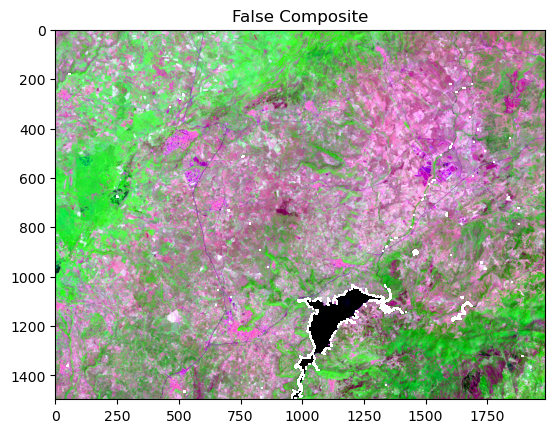

In [21]:
# Apply the normalisation function to each band
swir_processed = normalisation_str_gm(swir, *contrast_stretch_percentile, gamma)
nir_processed = normalisation_str_gm(nir, *contrast_stretch_percentile, gamma)
blue_processed = normalisation_str_gm(blu, *contrast_stretch_percentile, gamma)

# Use np.dstack to create a false-colour composite from the processed bands
false_composite= np.dstack((swir_processed, nir_processed, blue_processed)).astype(np.float32)

# Output:
plt.imshow(false_composite)
plt.title('False Composite')

And, by applying once more the equalisation function, we level up our composite, making it possible to appreciate the state of the vegetation in the area of interest.

Text(0.5, 1.0, 'Equalised False Composite')

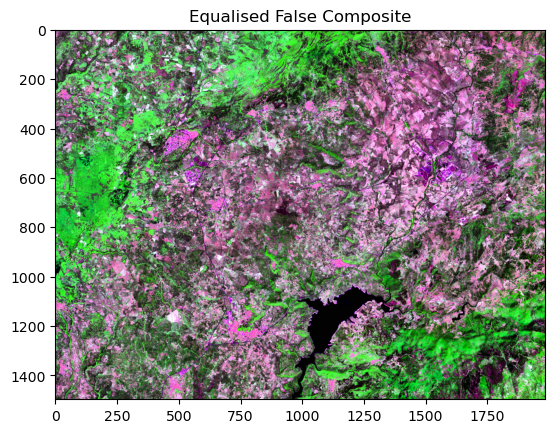

In [22]:
# Apply adaptive histogram equalisation to enhance contrast for fire detection
fire_fc = exposure.equalize_adapthist(false_composite)

# Create a figure to plot

plt.imshow(fire_fc)
plt.title('Equalised False Composite')

## Post-Fire Visualisation

Now, we will replicate the same visualisation for a specific time after the fire.<br>
Considering this new date, we will retrieve images from the same collection that correspond to our new timeframe of interest.

In [23]:
date_post = post_f + 'T00:00:00Z/' + post_f + 'T23:59:59.999999Z' # interest period

s2_post = list(eopf_catalog.search(
                bbox= search_bbox, 
                datetime= date_post,
                collections=def_collection).item_collection())

av_urls = [item.assets["product"].href for item in s2_post]

We open again the first available item from our filtered results to begin the post-fire analysis, followed by the masking and validation steps to ensure a clean, cloud-free composite.

In [24]:
post_zarr = xr.open_datatree(
    av_urls[-1], engine="zarr", #we always get the earliest one (last)
    chunks={},
    )

zarr_meas = post_zarr.measurements.reflectance.r20m

# Extractthe cloud free mask at 20m resolution:
l2a_class_20m = post_zarr.conditions.mask.l2a_classification.r20m.scl

valid_mask = validate_scl(l2a_class_20m)  # Boolean mask (10980x10980)

/var/folders/hr/vlzgj7wj51l7ps0dxp4wp08r0000gn/T/ipykernel_2039/1513901952.py:1: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  post_zarr = xr.open_datatree(
/var/folders/hr/vlzgj7wj51l7ps0dxp4wp08r0000gn/T/ipykernel_2039/1513901952.py:1: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, wh

### True Colour Image

Once the cleaned data is ready, we can generate the corresponding TCI to get an updated optical view after the fire event.<br>

We mask the interest assets.

In [25]:
# Create UTM masks for rows and columns based on the bounding box.
cols_post, rows_post = zarr_mask_utm(bbox_utm, zarr_meas)

# Select the red, green, and blue bands and apply the valid mask.
red = zarr_meas[tc_red].where(valid_mask)
gre =  zarr_meas[tc_green].where(valid_mask)
blu =  zarr_meas[tc_blue].where(valid_mask)

# Mask and clip the selected bands using the row and column indices.
red = mask_sub_utm(red,rows_post, cols_post).values
gre = mask_sub_utm(gre,rows_post, cols_post).values
blu = mask_sub_utm(blu,rows_post, cols_post).values

# Slice the y-dimension values using the new row indices.
y_zarr = zarr_meas['y'].isel(y=slice(rows_post.min(), rows_post.max() + 1)).values
# Slice the x-dimension values using the new column indices.
x_zarr = zarr_meas['x'].isel(x=slice(cols_post.min(), cols_post.max() + 1)).values

# We transform the original x,y bbox from our clip to decimal degree coordinates
map_ext_deg_post = list(t_utm_to_deg.transform(np.nanmin(x_zarr),np.nanmin(y_zarr)) + 
                   t_utm_to_deg.transform(np.nanmax(x_zarr),np.nanmax(y_zarr)))

And, once the new area is defined, we normalise, stack and equalize the new composite.

Text(0.5, 1.0, 'Equalised Composite')

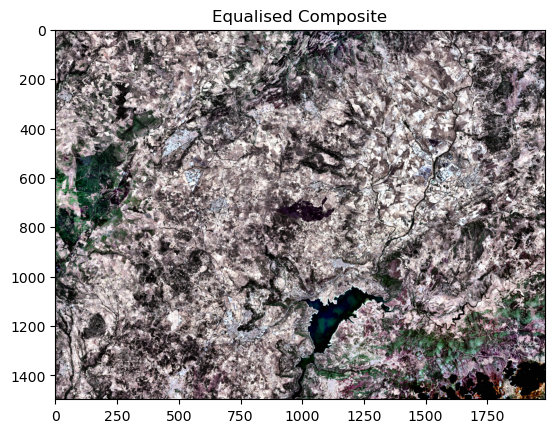

In [26]:
# Apply normalisation and gamma correction to the red, green, and blue bands.
red_processed = normalisation_str_gm(red, *contrast_stretch_percentile, gamma)
green_processed = normalisation_str_gm(gre, *contrast_stretch_percentile, gamma)
blue_processed = normalisation_str_gm(blu, *contrast_stretch_percentile, gamma)

# Stack the processed bands to create a single true-colour composite image.
rgb_composite_sm = np.dstack((red_processed, green_processed, blue_processed)).astype(np.float32)

# Apply adaptive histogram equalisation to enhance the composite image.
tc_post = exposure.equalize_adapthist(rgb_composite_sm)

plt.imshow(tc_post)
plt.title('Equalised Composite') # Add a title for clarity

### False Colour Image

And as the last processing step, we create the FCI for the same day, to clearly visualise the extent of the burn scars and vegetation recovery.

Text(0.5, 1.0, 'Equalised Composite')

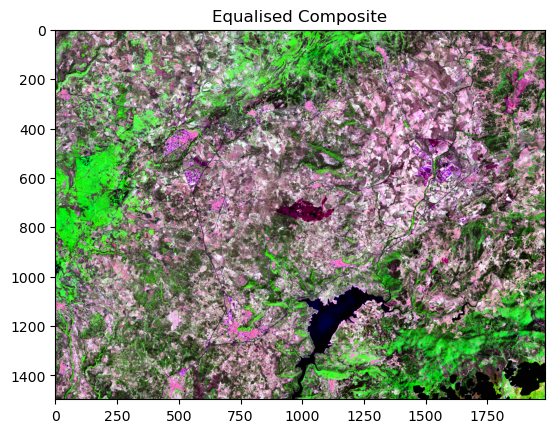

In [27]:
# Select the red, green, and blue bands and apply the valid mask.

swir = zarr_meas[fc_swir].where(valid_mask)
nir =  zarr_meas[fc_nir].where(valid_mask)
blu =  zarr_meas[fc_blue].where(valid_mask)

# Mask and clip the selected bands using the row and column indices.

swir = mask_sub_utm(swir,rows_post, cols_post).values
nir = mask_sub_utm(nir,rows_post, cols_post).values
blu = mask_sub_utm(blu,rows_post, cols_post).values

# Apply normalisation and gamma correction to the red, green, and blue bands.

swir_processed = normalisation_str_gm(swir, *contrast_stretch_percentile, gamma)
nir_processed = normalisation_str_gm(nir, *contrast_stretch_percentile, gamma)
blue_processed = normalisation_str_gm(blu, *contrast_stretch_percentile, gamma)


# Stack the processed bands to create a single false-colour composite image.
false_composite= np.dstack((swir_processed, nir_processed, blue_processed)).astype(np.float32)

# Apply adaptive histogram equalisation to enhance the composite image.
fc_post = exposure.equalize_adapthist(false_composite)

plt.imshow(fc_post)
plt.title('Equalised Composite') # Add a title for clarity

To finalise the process, we will **georeference** and **visualise** our data, presenting it in a way that makes it easier to recognise and understand the monitored areas.<br>

We will use the `cartopy` library to pinpoint the location of our georeferenced datasets based on their CRS and geospatial bounding box. The visualisation will be a 2x2 matrix, offering a comprehensive, multi-channel overview.<br>

Finally, the plot will be enhanced by adding key elements such as grid lines for improved geolocation, a clear title, and a bounding box to highlight the specific area of the fire. This approach allows for a direct visual comparison of the landscape's state before and after the event.


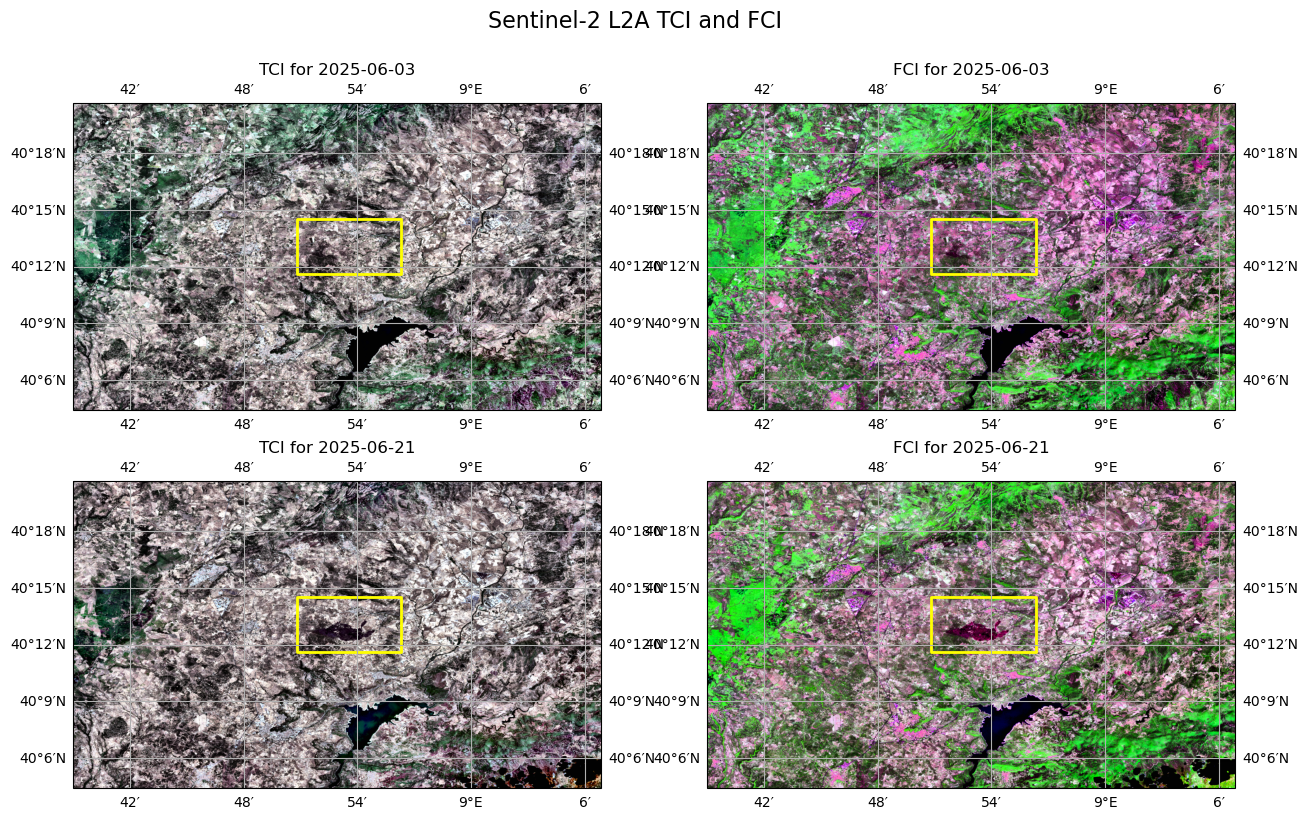

In [28]:
data_ll = ccrs.PlateCarree()

fig, axs = plt.subplots(2, 2, figsize=(15, 9), subplot_kw={'projection': data_ll})

# Pre fire TCI
ax1 = axs[0,0]
ax1.imshow(fire_tc, origin='upper',
                extent=[map_ext_deg_pre[0],map_ext_deg_pre[2],
                        map_ext_deg_pre[1],map_ext_deg_pre[3]],  # item
                transform=data_ll)
ax1.add_geometries(map_box, crs=data_ll, facecolor='none', 
                   edgecolor='yellow', linewidth=2, linestyle='-')
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False) # gridlines and labels
ax1.set_title(f'TCI for {pre_f}')

# Pre fire FCI
ax2 = axs[0,1]
ax2.imshow(fire_fc, origin='upper',
                extent=[map_ext_deg_pre[0],map_ext_deg_pre[2],
                        map_ext_deg_pre[1],map_ext_deg_pre[3]],  # item
                transform=data_ll)
ax2.add_geometries(map_box, crs=data_ll, facecolor='none', 
                   edgecolor='yellow', linewidth=2, linestyle='-')
ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False) # gridlines and labels
ax2.set_title(f'FCI for {pre_f}')

#Post fire TCO
ax3 = axs[1,0]
ax3.imshow(tc_post, origin='upper',
                extent=[map_ext_deg_post[0],map_ext_deg_post[2],
                        map_ext_deg_post[1],map_ext_deg_post[3]],  # item
                transform=data_ll)
ax3.add_geometries(map_box, crs=data_ll, facecolor='none', 
                   edgecolor='yellow', linewidth=2, linestyle='-')
ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False) # gridlines and labels
ax3.set_title(f'TCI for {post_f}')

# Post fire FCI
ax4 = axs[1,1]
ax4.imshow(fc_post, origin='upper',
                extent=[map_ext_deg_post[0],map_ext_deg_post[2],
                        map_ext_deg_post[1],map_ext_deg_post[3]],  # item
                transform=data_ll)
ax4.add_geometries(map_box, crs=data_ll, facecolor='none', 
                   edgecolor='yellow', linewidth=2, linestyle='-')
ax4.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False) # gridlines and labels
ax4.set_title(f'FCI for {post_f}')

# Adjust the layout to prevent titles from overlapping
fig.suptitle(f'Sentinel-2 L2A TCI and FCI', fontsize=16)
# Display the combined plot
plt.show()

In [29]:
et = time.time()

total_t = et - st

print('Total Running Time: ', total_t,' seconds')

Total Running Time:  48.26194477081299  seconds


As our plots show, the **True Colour Image** reveals a clear change in the state of the vegetation, with an evident burn scar visible on the ground. The **False Colour Image** also highlights a significant change in the spectral response, which precisely encloses the spot where the fire occurred.<br>

It is important to note the efficiency of this monitoring workflow. The entire process from defining the area of interest to searching, accessing, processing, and visualising the data takes less than a minute, highlighting the power of a streamlined approach with the `.zarr` format.<br>

We do not need to pre-download any of the assets, as they are already available in the cloud.


<hr>

## Conclusion

Having processed the key spectral bands, we have successfully established a visual baseline for **our monitoring workflow**.<br>

The generation of these composites allows us to quickly gain an overview of the spatial changes resulting from a fire event, as seen in **satellite imagery**.<br>

This workflow is **highly replicable**, enabling us to replicate these defined steps at various points in time. This ability to generate consistent visualisations will allow us to understand the full dynamics of a **fire’s event lifecycle** over time, from its beginning to the subsequent recovery of the landscape.


<hr>

## What’s next?

In the next tutorial, we will apply the workflow we have generated to create a True Colour Image from Sentinel-2 L2A data for the day of the fire. <br>

To obtain a more detailed overview of the fire's state, we will integrate a new dataset into our workflow: **Sentinel-3** data. This will enable us to analyse thermal information and pinpoint the active fire's location.